In [1]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

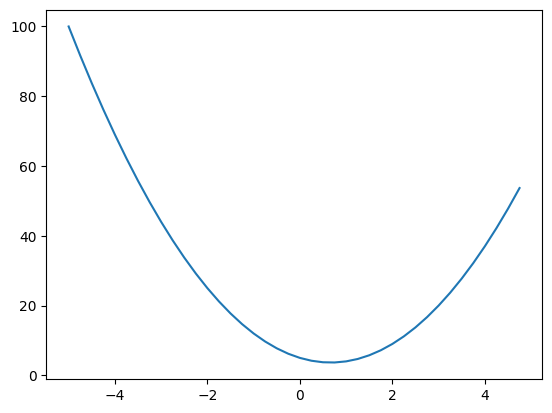

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [19]:
h = 0.00001
x = 2/3
(f(x + h) - f(x)) / h

3.0000002482211127e-05

In [20]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [24]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print("d1 = ", d1)
print("d2 = ", d2)
print("slope = ", (d2 - d1) / h)

d1 =  4.0
d2 =  4.0001
slope =  0.9999999999976694


In [110]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return (-self) + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

print(d)
print(d._prev)
print(d._op)

Value(data=4.0)
{Value(data=10.0), Value(data=-6.0)}
+


In [111]:
a = Value(3.0, label='a')
1 + a

Value(data=4.0)

In [49]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a ('rectangular') node for it
        dot.node(name=uid, label="%s | data %.4f | grad %.4f" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create a rectangular node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [51]:
L.grad = 1.0

L = d * f

Then what is dL/dd? Well it must be f

Why?

dL/dd = ( L(d + h) - L(d) ) / h
      = ( (d + h)*f - d*f) / h
      = ( h * f ) / h
      = f

In [53]:
d.grad = f.data
f.grad = d.data

print(d.grad)
print(f.grad)

-2.0
4.0


To get gradient w.r.t c, let's use chain rule

What is dd/dc? That's just 1.0

Why?

Because d = e + c and

dd/dc = ( d(c + h) - d(c) ) / h
      = ( e + c + h - e - c ) / h
      = h / h
      = 1.0

Using chain rule, 

dL/dc = dL/dd * dd/dc

and 

dL/de = dL/dd * dd/de

In [55]:
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0

Finally, e = a*b

Again, using chain rule:

dL/da = dL/de * de/da

and

dL/db = dL/de * de/db

In [57]:
a.grad = e.grad * b.data
b.grad = e.grad * a.data

print(a.grad)
print(b.grad)

6.0
-4.0


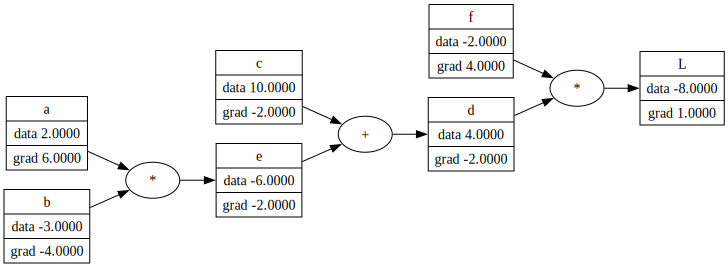

In [58]:
draw_dot(L)

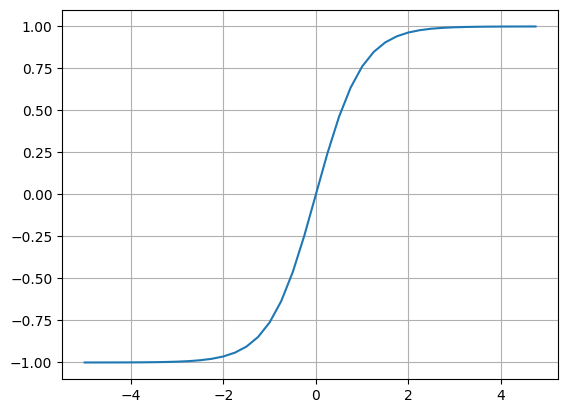

In [59]:
plt.plot(xs, np.tanh(xs)); plt.grid();

In [112]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# y = x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# o = tanh(n)
o = n.tanh(); o.label = 'o'

o.backward()

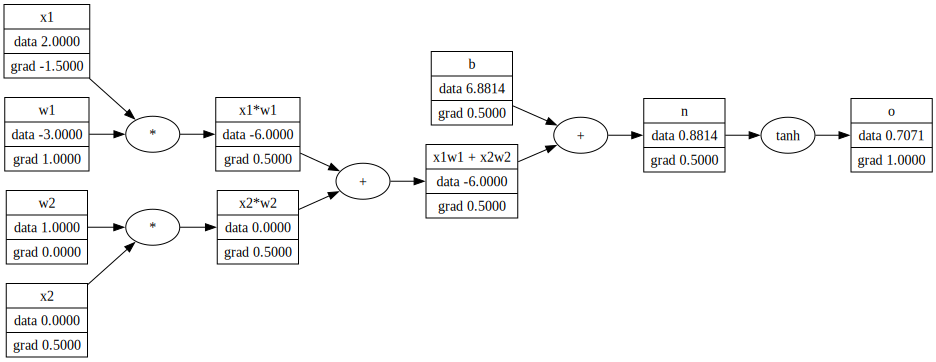

In [113]:
draw_dot(o)

In [94]:
o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
for node in reversed(topo):
    node._backward()

print(w1.grad)
print(w2.grad)
print(x1.grad)
print(x2.grad)
print(b.grad)

0.9999999999999998
0.0
-1.4999999999999996
0.4999999999999999
0.4999999999999999


In [89]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
print(topo)

[Value(data=6.881373587019543), Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=2.0), Value(data=-3.0), Value(data=-6.0), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


In [79]:
o.grad = 1.0
o._backward()

In [81]:
n._backward()

In [83]:
b._backward()
print(b.grad)

0.4999999999999999


In [85]:
x1w1x2w2._backward()

In [87]:
x1w1._backward()
x2w2._backward()

In [74]:
o.grad = 1.0
# dtanh(o)/do = 1 - o^2
n.grad = (1 - o.data**2) * o.grad
# n = x1w1 + x2w2 + b
x1w1x2w2.grad = n.grad * 1.0
b.grad = n.grad * 1.0

x1w1.grad = x1w1x2w2.grad * 1.0
x2w2.grad = x1w1x2w2.grad * 1.0

# xw = x * w
x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data

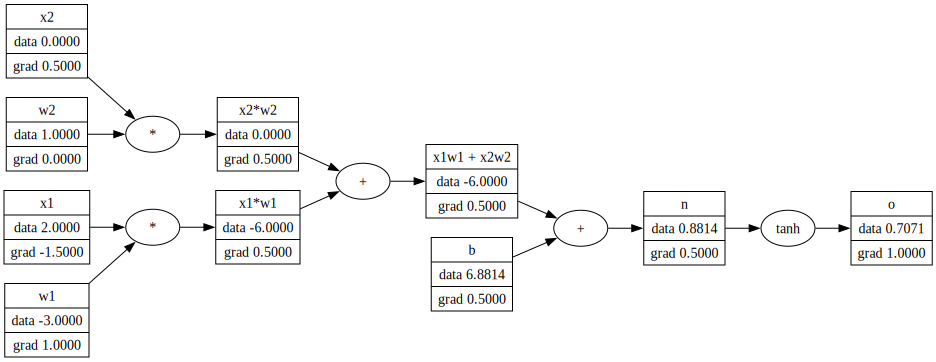

In [75]:
draw_dot(o)

Andrej found a bug! But it was related to setting gradients in _backward() rather than adding values of gradients (we already took care of that)

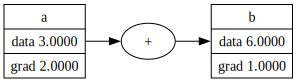

In [101]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

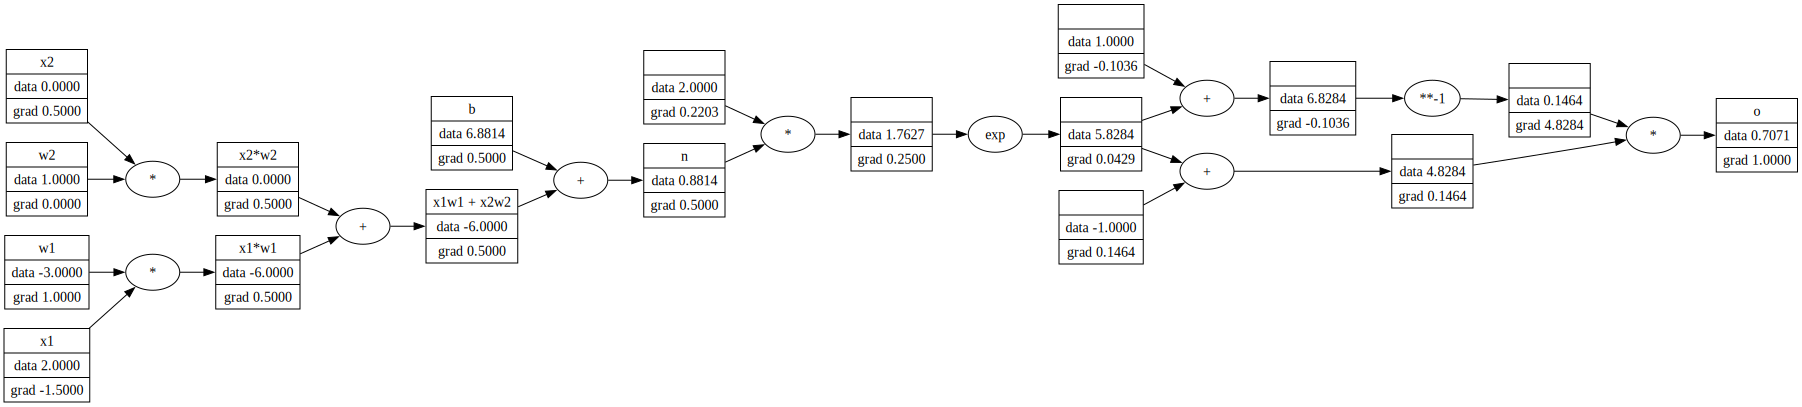

In [114]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# y = x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# --------------------------
e = (2*n).exp()
o = (e-1) / (e+1); 
# --------------------------
o.label = 'o'

o.backward()
draw_dot(o)

### Now let's do the same thing in Pytorch!

In [116]:
import torch

x1 = torch.Tensor([2.0]).double()                   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()                  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())

o.backward()

print('-----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Next, let's create a MLP using our micrograd engine!

In [187]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        # x * w + b
        act = sum((x_i * w_i for x_i, w_i in zip(x, self.w)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
mlp = MLP(3, [4, 4, 1])
x = [2.0, 3.0, -1.0]
print(mlp(x))

Value(data=0.3835750477589028)


In [188]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

for k in range(1000):

    # forward pass
    ypreds = [mlp(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypreds))

    # backward pass
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in mlp.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 4.27362995341946
1 3.7812603434283467
2 3.4217502423535504
3 3.163264338391076
4 2.9672048546617518
5 2.800643916033473
6 2.639575285430478
7 2.4637464984109467
8 2.2514233457703283
9 1.9785022026834878
10 1.6272747302084363
11 1.2187724686519341
12 0.8380751366917842
13 0.5690768870568264
14 0.4073946539463357
15 0.3097881670243979
16 0.24664569585109658
17 0.20304065003864014
18 0.17137608520717132
19 0.14748395712196813
20 0.12890664450871844
21 0.1141077590371261
22 0.10208088790387629
23 0.09214130989670852
24 0.08380830893177593
25 0.07673532847217746
26 0.07066678793323922
27 0.06541044413980848
28 0.06081916942795027
29 0.05677862430991444
30 0.0531987267428653
31 0.05000762882377447
32 0.04714738674797215
33 0.04457079722001863
34 0.04223905195076731
35 0.04011997531975078
36 0.03818668394549829
37 0.03641655566471219
38 0.03479042826423355
39 0.03329197078989021
40 0.03190718587210027
41 0.03062401250441997
42 0.029432006553056857
43 0.028322081933709005
44 0.02728629951988

In [189]:
ypreds

[Value(data=0.9916524054934018),
 Value(data=-0.9887021225297881),
 Value(data=-0.9924943185590237),
 Value(data=0.9868094997263667)]

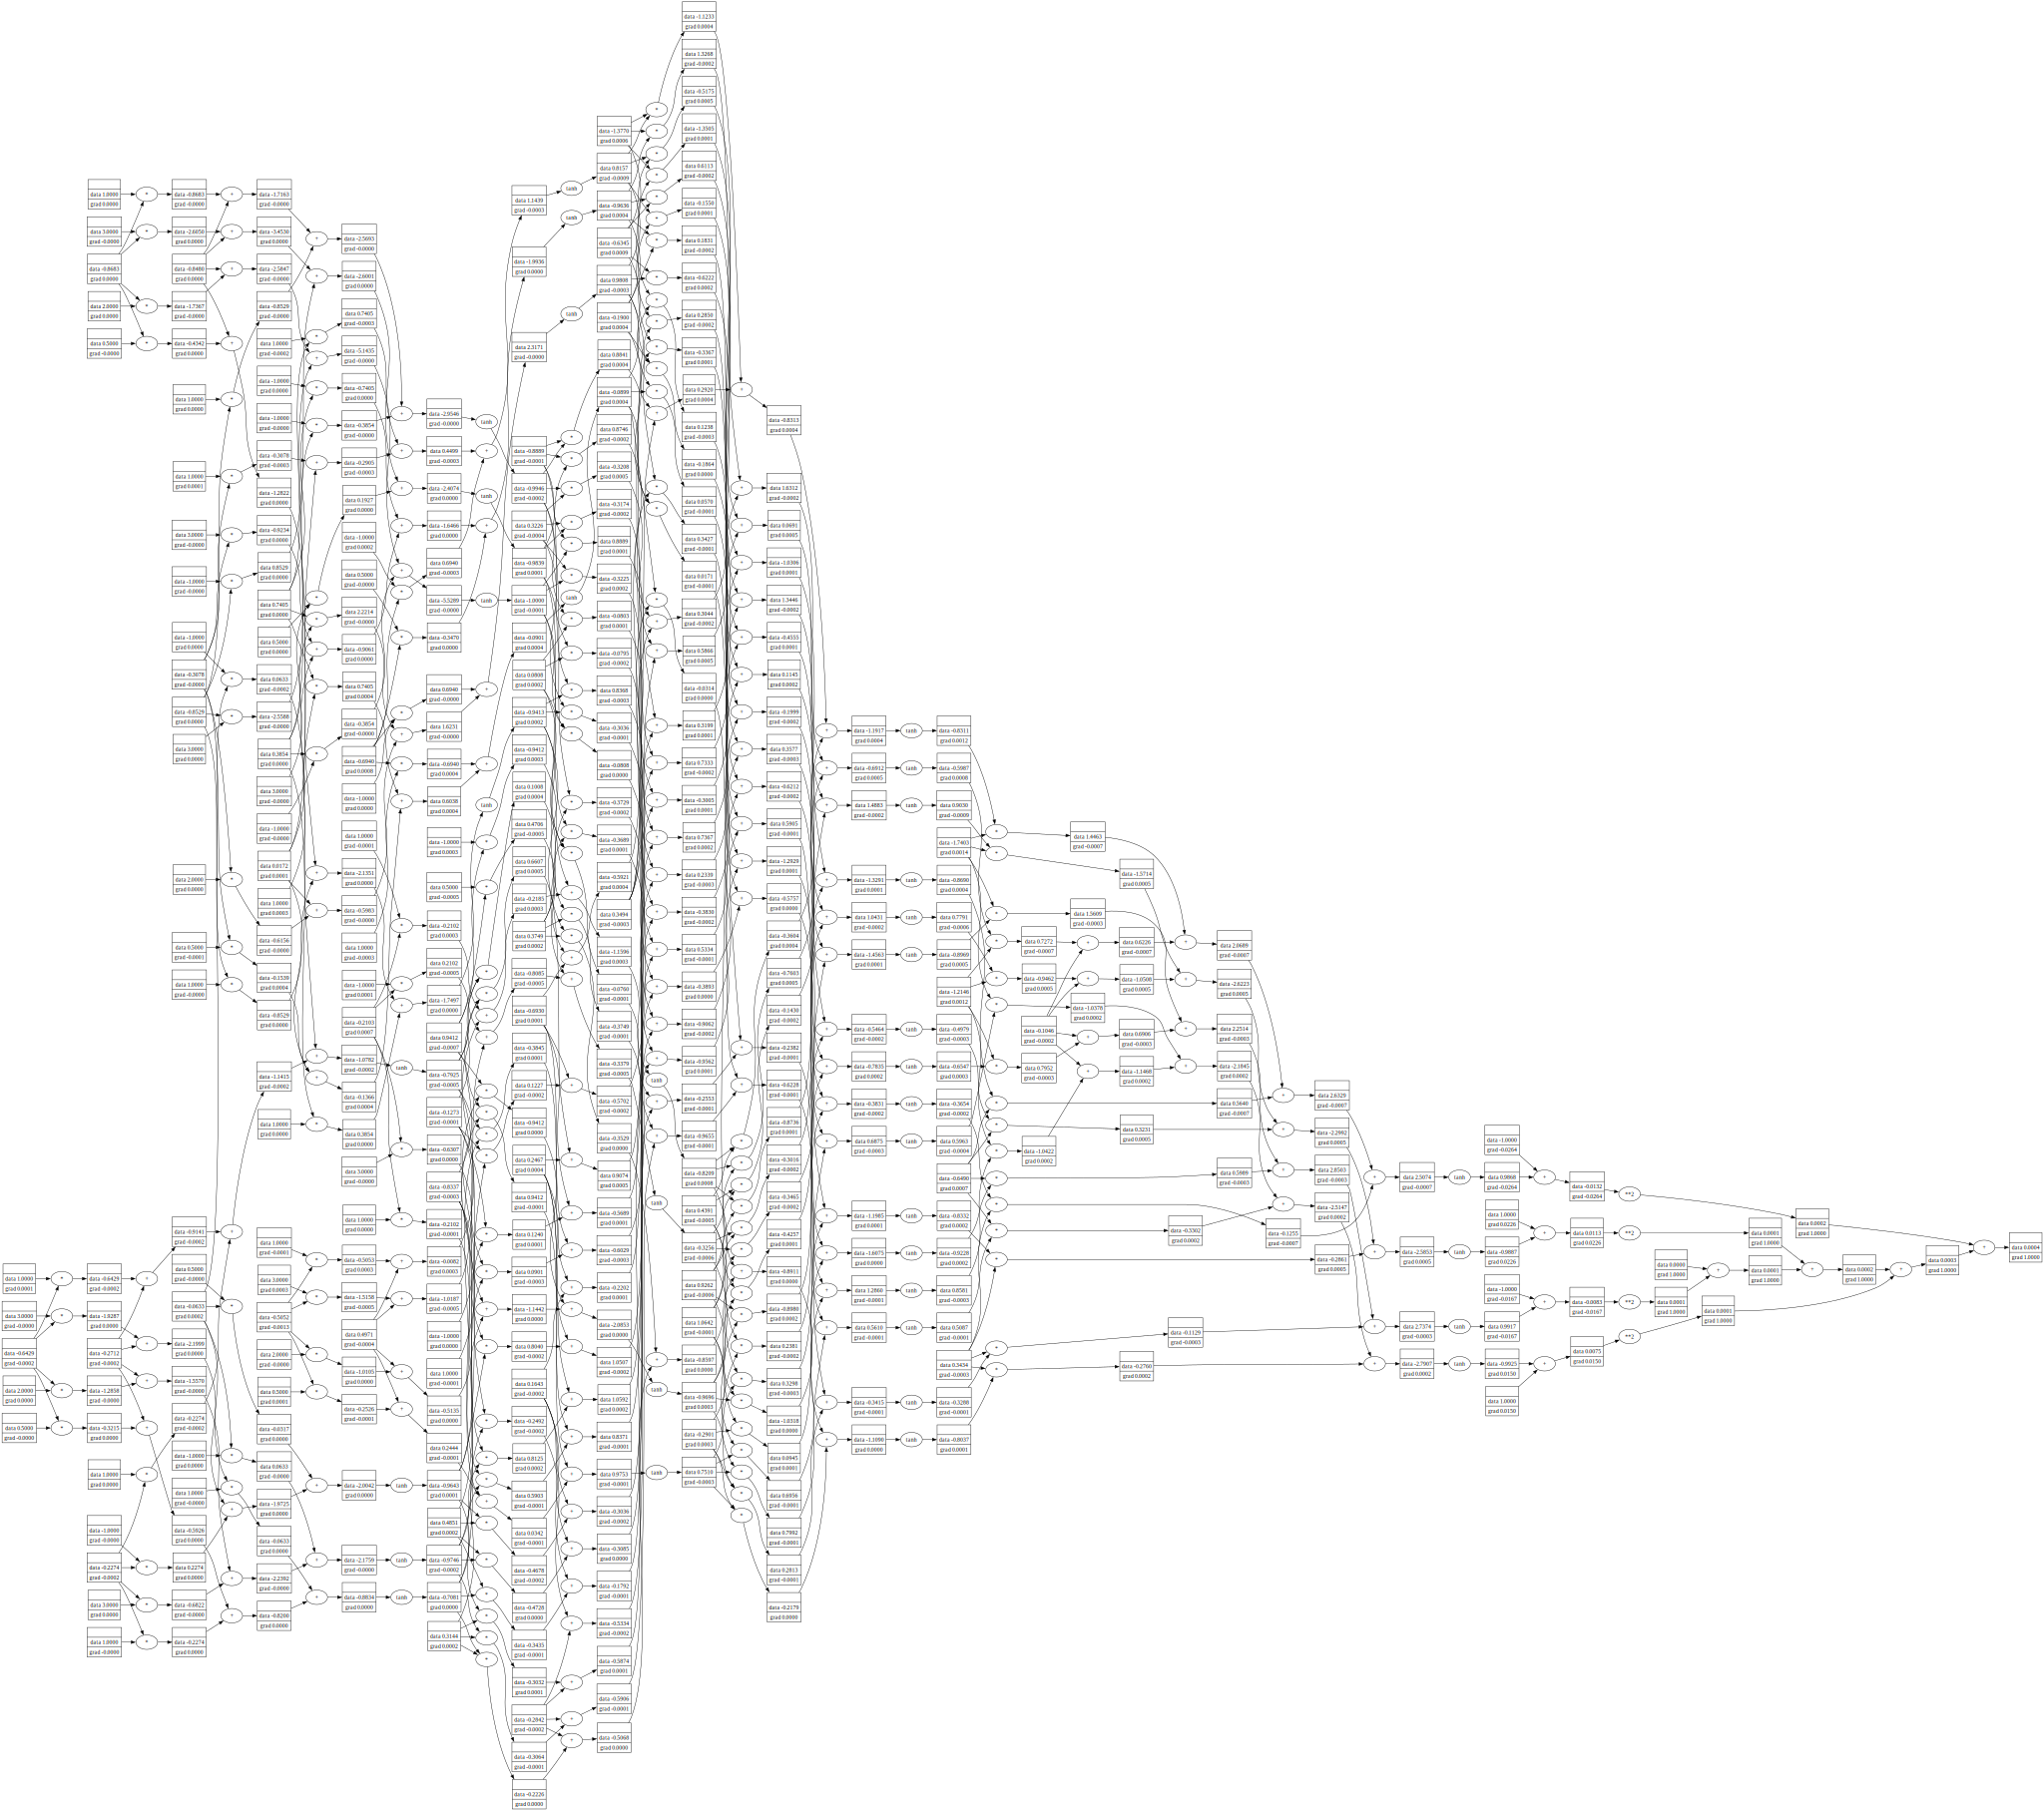

In [190]:
draw_dot(loss)